In [1]:
%load_ext autoreload
%autoreload 2

# Week 2: Fine-tuning Embeddings for RAG Applications

> **Prerequisites**: Please complete Week 1's notebooks before starting this one. The concepts build directly on that foundation.

Most teams avoid fine-tuning their embedding models, thinking they need tons of data and complex setups. But our experience shows that with just 100-200 thoughtfully created examples, you can significantly improve your model's performance over general-purpose embeddings.

## Why This Matters

Fine-tuning embedding models gives several key advantages over using general-purpose models. While it takes more upfront work to create training data and run the fine-tuning process, this investment typically leads to:

1. Much better accuracy on your specific tasks
2. Lower running costs through using smaller, more efficient models
3. Better handling of domain-specific language and context

## What You'll Learn

Through this tutorial, you'll discover how to:

1. Build Quality Training Data

- Generate synthetic transactions systematically
- Review and validate examples manually
- Create diverse, representative samples

2. Structure Your Dataset

- Define clear schema for transactions
- Add meaningful metadata
- Ensure data consistency

3. Establish Performance Baselines

- Measure initial embedding performance
- Calculate retrieval metrics
- Set up evaluation pipelines

By the end of this notebook, you'll know how to create high-quality synthetic data for fine-tuning embedding models. This prepares you for the hands-on fine-tuning work in notebooks 2 and 3, where we'll use both Cohere's managed service and open-source tools to improve retrieval performance.

## Case Study: Ramp's Transaction Categorization

> Read about Ramp's succesful case study using fine-tuned embeddings [here](https://engineering.ramp.com/transaction-embeddings)

We'll follow Ramp's successful approach to fine-tuning embeddings for transaction categorization. Their team demonstrated that even with unique customer categories, a fine-tuned model could effectively generalize to new customers and scenarios.

Using synthetic financial data, we'll walk through their process step by step:

1. **Data Understanding**: Learn what transaction data looks like and how to structure it for embedding
2. **Synthetic Data Generation**: Create realistic, challenging test cases using large language models
3. **Model Fine-tuning**: Compare performance between base and fine-tuned models

Throughout this process, we'll use Logfire to track experiments and measure improvements systematically. This workflow will give you a practical foundation for fine-tuning embeddings in your own applications.


### Understanding Transactions

To fine-tune our model effectively, we need to understand the transaction data we're working with.

Typical Transaction Fields:

- Merchant Name: The vendor or service provider's name.
- Merchant Category Code (MCC): General category of the transaction (e.g., Restaurants).
- Department Name: The company department responsible for the transaction.
- Location: Where the transaction took place.
- Amount: The transaction's monetary value.
- Spend Program Name: Specific budget or spend limit allocated.
- Trip Name: If the transaction occurred during travel.

We can see an example below

```
Name : Beirut Bakery
Category: Restaurants, Cafeteria
Department: Engineering
Location: Calgary, AB, Canada
Amount: 56.67 CAD
Card: Ramp's Physical Card
Trip Name: unknown
```

This is a difficult task because there's very little information. Additionally since each company has unique categories that have some implicit rules, it's difficult for a general embedding model to classify these transactions without fine-tuning.


## Generating Synthetic Transactions

We'll generate a synthetic transaction dataset in 3 steps

1. **Initial Examples** : We'll create a batch of basic transactions using `gpt-4o-mini` and manually review them to create a small dataset of good and bad examples.

2. **Refine Data** : We'll then randomly select a subset of these initial examples and use them to generate new examples that are more challenging by adding them to the prompt as few shot examples.

3. **Logfire Evaluation** : We'll then use `Logfire` to evaluate the recall@1,3,5 and mrr@1,3,5 of our initial and refined examples.

We recommend using `ChatGPT` to evaluate these examples and get a sense for what makes a good or bad example during this process. We'll iterate on this until we've generated at least 300 examples. This will ensure that we have enough examples to fine-tune a cohere re-ranker ( requires min 256 examples) or a sentence transformer model while also having enough examples to create a held out evaluation set.

There are two key advantages to iteratively generating our dataset in small batches

1. **Practicality** : A small amount of data is easy to label
2. **Randomness** : By constantly sampling from our growing number of examples, we're able to have enough randomness to create a diverse dataset. This helps us to avoid potential issues with diversity and quality that doing a single pass of data generation can introduce.

### Step 1 : Generating our initial transactions.

We'll start by generating our initial transactions using a simple prompt. These are going to be very simple examples that will not be great but they are useful as an initial starting point.


In [2]:
from pydantic import BaseModel, field_validator, ValidationInfo
from openai import AsyncOpenAI
import instructor
from typing import Optional
from textwrap import dedent
import random
import json
import asyncio

# Load in pre-defined categories
categories = json.load(open("data/categories.json"))


# Define a Pydantic model that can represent the same transaction data that Ramp was using
class Transaction(BaseModel):
    merchant_name: str
    merchant_category: list[str]
    department: str
    location: str
    amount: float
    spend_program_name: str
    trip_name: Optional[str] = None
    expense_category: str

    def format_transaction(self):
        return dedent(
            f"""
        Name : {self.merchant_name}
        Category: {", ".join(self.merchant_category)}
        Department: {self.department}
        Location: {self.location}
        Amount: {self.amount}
        Card: {self.spend_program_name}
        Trip Name: {self.trip_name if self.trip_name else "unknown"}
        """
        )

    @field_validator("expense_category")
    @classmethod
    def validate_expense_category(cls, v, info: ValidationInfo):
        # We use this later to read in the generated transactions
        if not info.context:
            return v

        # Validate that we've generated the right expense category
        assert v == info.context["category"]["category"], (
            f"The transaction must have an expense category of {info.context['category']['category']} instead of {v}"
        )
        return v


client = instructor.from_openai(AsyncOpenAI())


async def generate_transaction(category):
    return await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """Generate a transaction for a tech company that could be filed under the category of {{ category }}. This should be distinct from the sample_transactions provided in the categories.json file

                - The spend program is a specific spending authority or allocation that has defined limits, rules, and permissions. It's like a virtual card or spending account set up for a specific purpose.
                - Merchant Category Name is a label that best describes the merchant of the transaction.
                - Merchant name should be realistic and not obviously made up.
                """,
            }
        ],
        context={"category": category},
        response_model=Transaction,
    )

/Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Generate 5 initial transactions and choose the category randomly
coros = []
for _ in range(5):
    coros.append(generate_transaction(random.choice(categories)))

transactions = await asyncio.gather(*coros)
with open("./data/generated_transactions.jsonl", "a") as f:
    for transaction in transactions:
        f.write(transaction.model_dump_json() + "\n")

In [4]:
from rich import print

print(transactions[0])

Transaction(
    merchant_name='TechBank USA',
    merchant_category=['Bank & Transaction Fees'],
    department='Finance',
    location='San Francisco, CA',
    amount=150.0,
    spend_program_name='Operational Expenses',
    trip_name=None,
    expense_category='Bank & Transaction Fees'
)

### Step 2 : Labeling Transactions

Now that we've generated a small set of initial transactions, please run `streamlit run label.py` to manually select transactions that you think might be difficult to classify.

> You can modify and edit the transaction details before approving them. Hot keys of ctrl + e ( approve ) and ctrl + r ( reject ) make this process much faster. Only approved transactions will be saved to `generated_transactions.jsonl` below. We'll then use these examples to generate a new set of transactions that are more challenging.

You can also manually override transaction details in the streamlit application. We recommend using `ChatGPT` or `Claude` to discuss and generate good default and examples. A prompt that I used to prompt the chat UI was

```
I'd like to generate a transaction for a tech company that is challenging to classify into a specific category. Here are the details

<Details go here>

I'd like you to help rewrite some of the details to make it more realistic. Please stick to the following rules

- MCCs should be realistic. If possible, let's try to use a MCC that will cover a superset of the given category
- Let's try to suggest a non-uniform number (Eg. not 1500 ) so that it seems more realistic
- The Spend Program name should be a specific spending authority or allocation that has defined limits, rules, and permissions. It's like a virtual card or spending account set up for a specific purpose. In our case, this spend program name should not be a name that directly mentions the category or merchant
```


In [5]:
async def generate_transaction_with_examples(category, examples: list[Transaction]):
    return await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """
                Generate a potentially ambiguous business transaction that could reasonably be categorized as {{ category }} or another similar category. The goal is to create transactions that challenge automatic categorization systems by having characteristics that could fit multiple categories.


                Available categories in the system.:
                <categories>
                {% for category_option in categories %}
                    {{ category_option["category"] }}
                {% endfor %}
                </categories>

                
                The transaction should:
                1. Use a realistic but non-obvious merchant name (international names welcome), don't use names that are obviously made u 
                2. Include a plausible but non-rounded amount with decimals (e.g., $1247.83)
                3. Be difficult to categorize definitively (could fit in multiple categories)
                4. Merchant Category Name(s) should not reference the category at all and should be able to be used for other similar categories if possible.

                Here are some good examples of transactions that were previously generated for other categories.

                {% for example in examples %}
                {{ example.model_dump_json() }}
                {% endfor %}
                """,
            }
        ],
        context={"category": category, "examples": examples, "categories": categories},
        response_model=Transaction,
    )

In [240]:
with open("./data/cleaned.jsonl", "r") as f:
    sample_transactions = []
    for line in f:
        sample_transactions.append(Transaction(**json.loads(line)))


coros = []
for _ in range(20):
    coros.append(
        generate_transaction_with_examples(
            random.choice(categories), random.sample(sample_transactions, 10)
        )
    )

transactions = await asyncio.gather(*coros)

with open("./data/generated_transactions.jsonl", "w") as f:
    for transaction in transactions:
        f.write(transaction.model_dump_json() + "\n")

### Step 3 : Evaluating Recall and MRR Performance.

> Make sure that you've setup Logfire before continuing with the following section. For instructions on how to do so, please refer to `week-0/3. Using Pydantic Evals`

Remember that we're building a model that can suggest transaction categories to a user. To do so, we'll only be able to show the top 3-5 results and we want to make sure that the correct result is ranked as highly as possible.

Therefore, we'll be using recall and mrr to evaluate our model's performance here.

- `recall` : This measures whether the correct category is in the top k retrieved results.
- `mrr` : This measures how highly is the correct category ranked in the retrieved results.

Ideally we want a model with a high recall and mrr. This means that when we display the results, they're likely to be relevant to the user. By measuring the recall and mrr, we're able to ensure that we're conssitently generating questions that the model finds challenging.

We're using `lancedb` here since it provides an easy way to perform these evaluations with automatic batching of embeddings for queries and data along with a single api for vector search and reranking.


In [6]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

func = get_registry().get("openai").create(name="text-embedding-3-small")
categories = json.load(open("data/categories.json"))


class Category(LanceModel):
    text: str = func.SourceField()
    embedding: Vector(func.ndims()) = func.VectorField()


db = lancedb.connect("./lancedb")
table = db.create_table("categories", schema=Category, mode="overwrite")


table.add(
    [
        {
            "text": category["category"],
        }
        for category in categories
    ]
)

table.create_fts_index(field_names=["text"], replace=True)

We can then read in our transactions that we've manually annotated using the `label.py` streamlit application

In [9]:
from rich import print

print(transactions[0])

Transaction(
    merchant_name='Tooly',
    merchant_category=['Survey Software', 'SaaS'],
    department='Marketing',
    location='San Francisco, CA',
    amount=2000.0,
    spend_program_name='Annual Marketing Technology Budget',
    trip_name=None,
    expense_category='Subscriptions & Memberships'
)

In [ ]:
from pydantic_evals import Dataset, Case

cases = []
for line in open("./data/cleaned.jsonl").readlines():
    transaction = Transaction(**json.loads(line))
    cases.append(
        Case(
            inputs=transaction.format_transaction(),
            expected_output=[transaction.expense_category],
        )
    )

dataset = Dataset(cases=cases)

In [55]:
from helpers import get_metrics_at_k, task
from dataclasses import dataclass
from pydantic_evals.evaluators import Evaluator, EvaluatorContext
from lancedb.table import Table
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import logfire


@dataclass
class RagMetricsEvaluator(Evaluator):
    async def evaluate(self, ctx: EvaluatorContext[str, str]) -> dict[str, float]:
        predictions = ctx.output
        labels = ctx.expected_output
        metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
        return {
            metric: score_fn(predictions, labels)
            for metric, score_fn in metrics.items()
        }


async def retrieve_results(
    question: str,
    table: Table,
    pool: ThreadPoolExecutor,
    max_k=25,
    reranker=None,
):
    loop = asyncio.get_running_loop()
    return await loop.run_in_executor(
        pool,
        partial(task, user_query=question, table=table, max_k=max_k, reranker=reranker),
    )


logfire.configure(
    send_to_logfire=True,
    environment="experimentation",
    service_name="synthetic-transactions",
    console=False,
)

dataset.add_evaluator(RagMetricsEvaluator())
with ThreadPoolExecutor(max_workers=10) as executor:
    evaluation_result = await dataset.evaluate(
        partial(retrieve_results, table=table, pool=executor)
    )


In [60]:
from tabulate import tabulate

def format_results(result):
    return tabulate(
        [[item, round(value,4)] for item, value in result.averages().scores.items()],
        headers=["Metric", "Score"],
    )

print(format_results(evaluation_result))

Metric      Score
--------  -------
mrr@1      0.3885
mrr@3      0.4981
mrr@5      0.5254
recall@1   0.3885
recall@3   0.6462
recall@5   0.7692

At this point, we've generated a large dataset of synthetic transactions that we can use to fine-tune a model on. However, it's important here to call out that synthetic data has its challenges.

1. Quality and Diversity : It's difficult to ensure that the synthetic data is of high quality and diverse. We've done so by manually reviewing and selecting good examples but ultimately we need real production data to ensure that our model is able to generalise.

2. Human Error : Manual review is great to ensure the quality of transactions but is expensive and error prone. This is not something that scales well, especially if you're trying to generate thousands of examples which you'd like humans to manually label.

We want to treat this synthetic data as a starting point and iteratively make it better using the techniques we've discussed in this notebook. But you will need to eventually mix in production data and continue generating synthetic data in order to adequately evaluate and test the generalisation capabilities of your model.


## Creating a Dataset

We want to segregate our data into a train and evaluation set because it allows us to evaluate the performance of our model on data that it hasn't seen before. 

We use `pydantic_evals` here to segregate our dataset into two separate yml files and store them in our `data` folder. This allows us to easily share and run evaluations on our model in the subsequent notebooks later on.


If we fine-tuned our model on the same data that we evaluated it on, it would be difficult to tell if the improvements we made were due to the model generalizing better or due to overfitting. In this case, we're just going to split our data by selecting the first 80% as our training set and the remaining 20% as our evaluation set.

In practice, you'd want to think carefully about these splits - using the category as a way to ensure that we have a diverse set of examples or generating new labels for the evaluation set based on the training labels. (Eg. Restaurants -> Dining Establishments or randomly grouping categories together )

Before we start fine-tuning our models here, we also need to make sure that the evaluation set and training set are similar. We do so by measuring the recall and mrr and verifying that they have similar values.


In [49]:
train_ratio = 0.8 * len(cases)

train_cases = cases[: int(train_ratio)]
eval_cases = cases[int(train_ratio) :]

In [50]:
train_dataset_path = "./data/train_transactions.yml"
eval_dataset_path = "./data/eval_transactions.yml"

train_dataset = Dataset(cases=train_cases)
train_dataset.to_file(train_dataset_path)

eval_dataset = Dataset(cases=eval_cases)
eval_dataset.to_file(eval_dataset_path)

We can validate that the dataset is formatted correctly by printing out the first item.


In [51]:
from rich import print

dataset = Dataset.from_file(train_dataset_path)
print(dataset.cases[0])

Case(
    name=None,
    inputs='\nName : Tooly\nCategory: Survey Software, SaaS\nDepartment: Marketing\nLocation: San Francisco, 
CA\nAmount: 2000.0\nCard: Annual Marketing Technology Budget\nTrip Name: unknown\n',
    metadata=None,
    expected_output=['Subscriptions & Memberships'],
    evaluators=[]
)

We can see that the dataset has the input formatted correctly as well as the expected output. Now let's see if our evaluation set and training set are similar.


In [65]:
train_dataset = Dataset.from_file(train_dataset_path)
eval_dataset = Dataset.from_file(eval_dataset_path)

print(len(train_dataset.cases), len(eval_dataset.cases))

260 66

In [66]:
from lancedb import connect
import concurrent

datasets = [["train", train_dataset], ["eval", eval_dataset]]

db = connect("./lancedb")
table = db.open_table("categories")

results = []
for dataset_name, dataset_partition in datasets:
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        dataset_partition.add_evaluator(RagMetricsEvaluator())
        result = await dataset_partition.evaluate(
            partial(retrieve_results, table=table, pool=executor)
        )
        results.append(result)

In [67]:
print(format_results(results[0]))

Metric      Score
--------  -------
mrr@1      0.3885
mrr@3      0.4981
mrr@5      0.5254
recall@1   0.3885
recall@3   0.6462
recall@5   0.7692

In [68]:
print(format_results(results[1]))

Metric      Score
--------  -------
mrr@1      0.3788
mrr@3      0.4798
mrr@5      0.5131
recall@1   0.3788
recall@3   0.6061
recall@5   0.7424

### Results and Analysis

Now let's visualise the scores for our evaluation and training datasets below

In [69]:
import pandas as pd

scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.averages().scores.items():
        result_scores[score_name] = score
    scores.append(result_scores)

df = pd.DataFrame(scores, index=["Train", "Eval"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Train,0.39,0.50,0.53,0.39,0.65,0.77
Eval,0.38,0.48,0.51,0.38,0.61,0.74


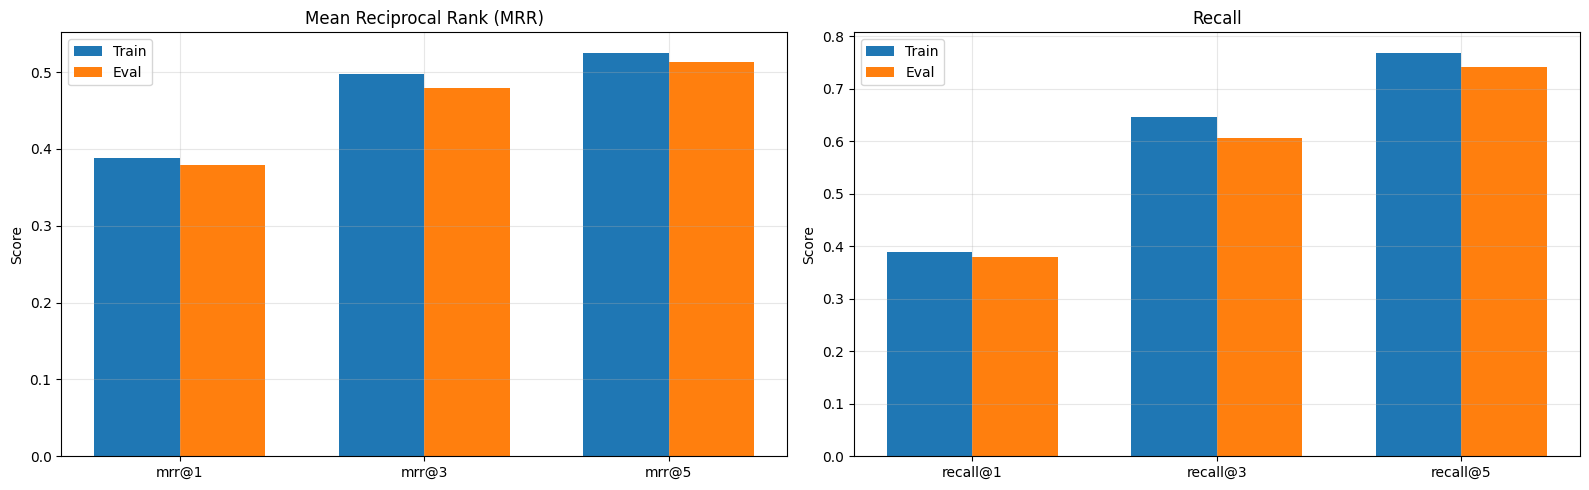

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Get MRR and Recall columns
mrr_cols = ["mrr@1", "mrr@3", "mrr@5"]
recall_cols = ["recall@1", "recall@3", "recall@5"]
x = np.arange(len(mrr_cols))
width = 0.35

# Plot MRR bars
ax1.bar(x - width / 2, df.loc["Train", mrr_cols], width, label="Train")
ax1.bar(x + width / 2, df.loc["Eval", mrr_cols], width, label="Eval")
ax1.set_title("Mean Reciprocal Rank (MRR)")
ax1.set_xticks(x)
ax1.set_xticklabels(mrr_cols)
ax1.set_ylabel("Score")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Recall bars
ax2.bar(x - width / 2, df.loc["Train", recall_cols], width, label="Train")
ax2.bar(x + width / 2, df.loc["Eval", recall_cols], width, label="Eval")
ax2.set_title("Recall")
ax2.set_xticks(x)
ax2.set_xticklabels(recall_cols)
ax2.set_ylabel("Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've laid the foundation for fine-tuning by creating high-quality synthetic training data. Our analysis shows that our train and eval sets have similar performance metrics, suggesting they represent the same underlying patterns and will give us reliable estimates of real-world performance.

While our approach works well for getting started, production systems need more robust testing - like generating similar but different labels, using multiple test sets, and carefully preventing data leakage. We'll explore some of these ideas in Week 4 when we look at handling different types of queries.

In the next two notebooks, we'll put this data to work: first using Cohere's managed re-ranker service as an easy starting point, then exploring open-source fine-tuning for more control. This builds on Week 1's evaluation framework while preparing us for more advanced query handling in future weeks.
